## Setup

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, InceptionV3,ResNet152V2, Xception, EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from absl import logging
logging.set_verbosity(logging.ERROR)

In [2]:
print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.7.0
• GPU Device Found.


## Read the processed data into the training dataset and validation dataset
The data in this directory has been previously cleaned, which finally obtained a dataset of 500 images in each class which is divided into 3 directories in the training directory as much as 80% or 400 images in each class, the Validation data as much as 10% or 100 images in each class, and the test data as much as 10% or 100 images in each class.

In [3]:
TRAINING_DIR = "Dataset_fix/train_dir/"
VALIDATION_DIR = "Dataset_fix/validation_dir/"
TEST_DIR = "Dataset_fix/test_dir/"

In [4]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
    train_datagen = ImageDataGenerator(rescale= 1./255.,
                                        rotation_range=45,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,             
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        fill_mode='nearest',
                                        horizontal_flip=True,
                                        vertical_flip=True)
    
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32,
                                                        color_mode='rgb',
                                                        class_mode="categorical",
                                                        target_size=(224, 224))

    
    validation_datagen = ImageDataGenerator(rescale=1./255.)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32,
                                                                  color_mode='rgb',
                                                                  class_mode="categorical",
                                                                  target_size=(224, 224))
    
    test_datagen = ImageDataGenerator(rescale=1./255.)
    
    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                      color_mode='rgb',
                                                      batch_size=32,
                                                      class_mode="categorical",
                                                      target_size=(224, 224))
    
    return train_generator, validation_generator, test_generator

In [5]:
train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR)

Found 8000 images belonging to 20 classes.
Found 1000 images belonging to 20 classes.
Found 1000 images belonging to 20 classes.


In [6]:
label_names = list(validation_generator.class_indices.keys())
print(f"{label_names} \nClass : {len(label_names)}")

['American_shorthair', 'Basset_hound', 'Beagle', 'Bengal', 'Boxer', 'British_Shorthair', 'Chihuahua', 'English_cocker_spaniel', 'Japanese_chin', 'Maine_Coon', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian_Blue', 'Samoyed', 'Scottish_fold', 'Siamese', 'Sphynx'] 
Class : 20


In [7]:
def plotImages(images_arr, folder_names):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, folder_name, ax in zip(images_arr, folder_names, axes):
        ax.imshow(img[:, :, 0])
        ax.axis('off')
        ax.set_title(folder_name)
    plt.tight_layout()
    plt.show()

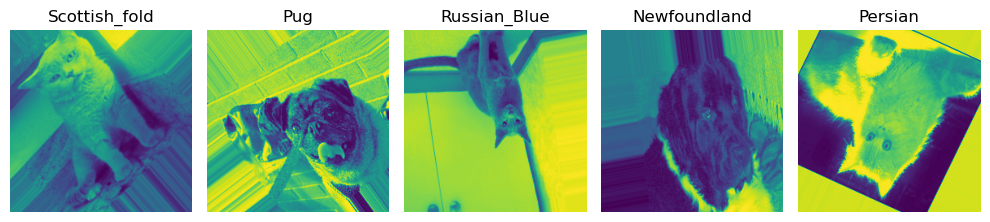

In [8]:
sample_training_images, labels = next(train_generator)
folder_names = [list(train_generator.class_indices.keys())[label.argmax()] for label in labels]

plotImages(sample_training_images[:5], folder_names)

## Creating a Callback class

In [9]:
callbacks = EarlyStopping(patience=10,
                          min_delta=0.001,
                          baseline=None,
                          mode='max',
                          monitor='val_accuracy',
                          restore_best_weights=True,
                          verbose=1
                         )

## Define, compile and Train the model

In [10]:
pre_trained_model = ResNet152V2(input_shape = (224, 224, 3), 
                                include_top = False)

for layer in pre_trained_model.layers:
    layer.trainable = False

234561536/234545216 [==============================] - 67s 0us/step


In [11]:
pre_trained_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [12]:
model = tf.keras.Sequential([
        pre_trained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),     
        tf.keras.layers.Dense(20,activation='softmax') 
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', 
              metrics=['accuracy']) 

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 20)                2580      
                                                                 
Total params: 109,780,628
Trainable params: 51,448,980
N

In [14]:
# Train the model
history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks]
                   )

Epoch 1/50
250/250 [==============================] - 195s 717ms/step - loss: 1.8622 - accuracy: 0.4881 - val_loss: 0.8937 - val_accuracy: 0.6910
Epoch 2/50
250/250 [==============================] - 136s 545ms/step - loss: 1.4072 - accuracy: 0.5754 - val_loss: 0.8321 - val_accuracy: 0.7290
Epoch 3/50
250/250 [==============================] - 137s 547ms/step - loss: 1.2329 - accuracy: 0.6152 - val_loss: 0.7532 - val_accuracy: 0.7480
Epoch 4/50
250/250 [==============================] - 138s 551ms/step - loss: 1.1839 - accuracy: 0.6306 - val_loss: 0.7556 - val_accuracy: 0.7480
Epoch 5/50
250/250 [==============================] - 158s 633ms/step - loss: 1.1298 - accuracy: 0.6403 - val_loss: 0.7258 - val_accuracy: 0.7460
Epoch 6/50
250/250 [==============================] - 180s 718ms/step - loss: 1.1119 - accuracy: 0.6429 - val_loss: 0.7143 - val_accuracy: 0.7540
Epoch 7/50
250/250 [==============================] - 171s 685ms/step - loss: 1.0326 - accuracy: 0.6653 - val_loss: 0.6865 -

### Training History

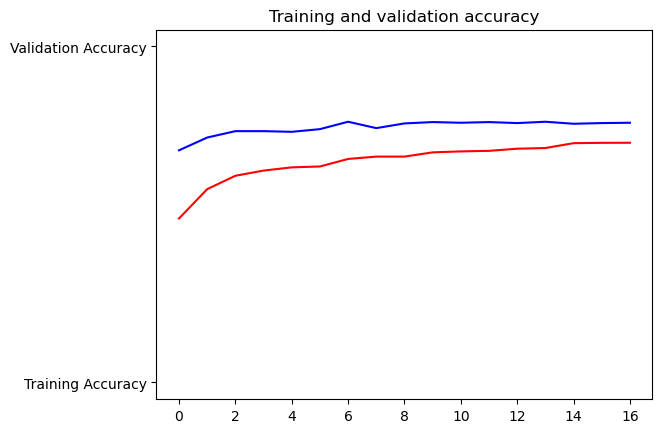

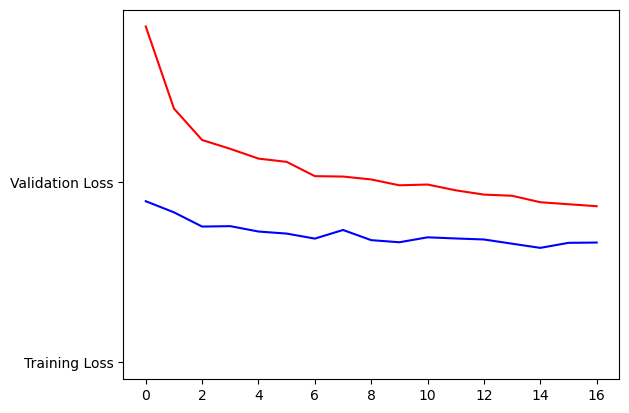

In [15]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

### Fine tune

In [16]:
pre_trained_model.trainable = True

for layer in pre_trained_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/50
250/250 [==============================] - 192s 721ms/step - loss: 0.9830 - accuracy: 0.6864 - val_loss: 0.6900 - val_accuracy: 0.7640
Epoch 2/50
250/250 [==============================] - 181s 724ms/step - loss: 0.9118 - accuracy: 0.6963 - val_loss: 0.6806 - val_accuracy: 0.7710
Epoch 3/50
250/250 [==============================] - 177s 707ms/step - loss: 0.8858 - accuracy: 0.7105 - val_loss: 0.6652 - val_accuracy: 0.7740
Epoch 4/50
250/250 [==============================] - 179s 716ms/step - loss: 0.8564 - accuracy: 0.7151 - val_loss: 0.6739 - val_accuracy: 0.7750
Epoch 5/50
250/250 [==============================] - 176s 702ms/step - loss: 0.8642 - accuracy: 0.7181 - val_loss: 0.6597 - val_accuracy: 0.7730
Epoch 6/50
250/250 [==============================] - 115s 459ms/step - loss: 0.8375 - accuracy: 0.7186 - val_loss: 0.6475 - val_accuracy: 0.7770
Epoch 7/50
250/250 [==============================] - 119s 474ms/step - loss: 0.8066 - accuracy: 0.7316 - val_loss: 0.6474 -

### Training History

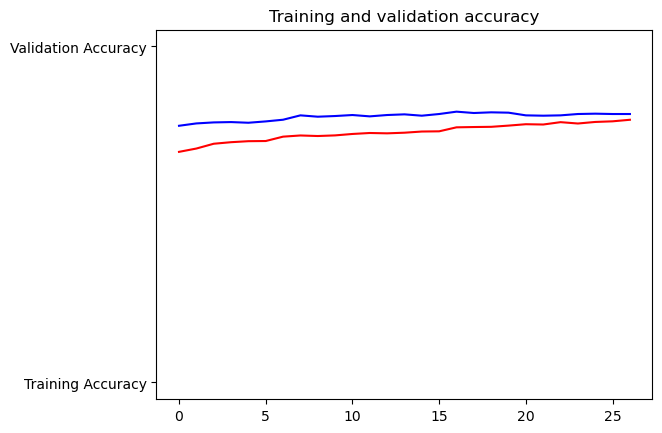

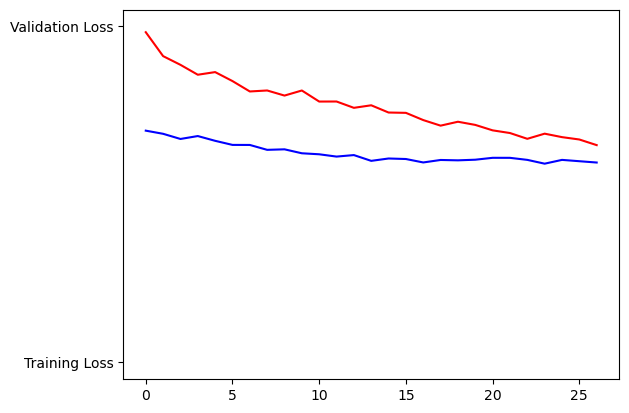

In [17]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

### Evaluate the Model

In [18]:
# Evaluate the model on the test images.
results = model.evaluate(test_generator)

for metric, value in zip(model.metrics_names, results):
    print(metric + ': {:.3}'.format(value))

32/32 [==============================] - 16s 488ms/step - loss: 0.5787 - accuracy: 0.8000
loss: 0.579
accuracy: 0.8


### Testing models with images that have never been used

In [19]:
def load_and_prep_image(filename, img_shape=224):
    # Read in target file (an image)
    img = tf.io.read_file(filename)
    
    # Decode the read file into a tensor & ensure 3 colour channels 
    # our model is trained on images with 3 colour channels 
    img = tf.image.decode_image(img, channels=3)
    
    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [img_shape, img_shape])
    
    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img
     

In [20]:
def pred_and_plot(model, filename, label_names):
    img = load_and_prep_image(filename)
    pred = model.predict(tf.expand_dims(img, axis=0))
    indeks_kolom = tf.where(tf.round(pred)[0] == 1)
    pred_class = label_names[int(indeks_kolom)]
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

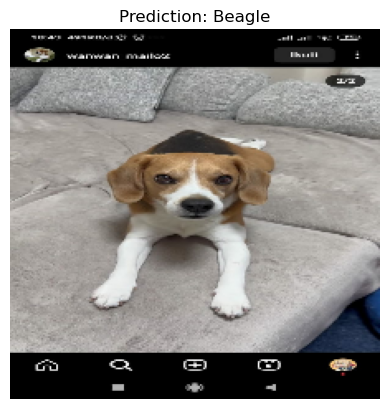

In [21]:
# Test our model on a custom image
pred_and_plot(model, "WhatsApp Image 2023-05-25 at 18.43.46.jpeg", label_names)

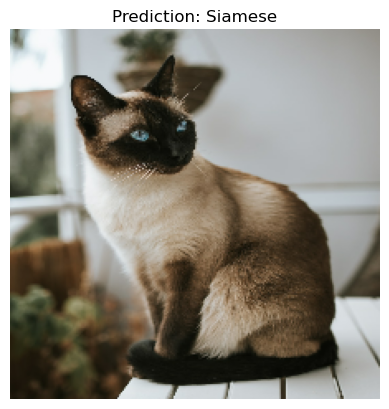

In [22]:
# Test our model on a custom image
pred_and_plot(model, "siamese_cat_2.jpg", label_names)

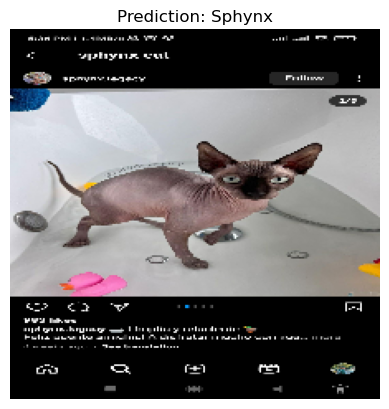

In [23]:
# Test our model on a custom image
pred_and_plot(model, "Screenshot_2023-05-26-17-36-11-408_com.instagram.android.jpg", label_names)